In [17]:
include("/home/n/nichollsh/lovepy/TidalLoveNumbers.jl")
using .TidalLoveNumbers
using Plots
using Printf
using DoubleFloats

# Get precision of Love number module (e.g., Float64, Double64, etc)
prec = TidalLoveNumbers.prec;    # Type of real numbers
precc = TidalLoveNumbers.precc;  # TYpe of complex numbers

In [2]:
gr()

Plots.GRBackend()

In [3]:
struct rheo_t
    dotl::prec
    delta::prec
    xi::prec
    gamma::prec
    phist::prec
end

B_ein::prec = 2.5

2.5

In [4]:
# Lookup parameters for rheological properties
# Taken from https://doi.org/10.1051/0004-6361/202039433
par_visc  = rheo_t(1.0,  25.7, 1.17e-9, 5.0, 0.4)
par_shear = rheo_t(10.0, 2.10, 7.08e-7, 5.0, 0.4)
par_bulk  = rheo_t(1e9,  2.62, 0.102,   5.0, 0.4)


rheo_t(1.0e9, 2.62, 0.102, 5.0, 0.4)

In [18]:

# Evalulate big Phi at a given layer
function _bigphi(phi, par)
    return (1.0-phi)/(1.0-par.phist)
end

# Evalulate big F at a given layer
function _bigf(phi, par)
    numer = sqrt(pi) * _bigphi(phi, par) * (1.0 + _bigphi(phi, par)^par.gamma)
    denom = 2.0 * (1.0 - par.xi)
    return (1.0-par.xi) * erf(numer/denom)
end

# Evalulate rheological parameter at a given layer
function eval_rheoparam(phi, which)
    if which == "visc"
        par = par_visc
    elseif which == "shear"
        par = par_shear
    elseif which == "bulk"
        par = par_bulk
    end
    # Evaluate parameter
    numer = 1.0 + _bigphi(phi, par)^par.delta
    denom = (1.0-_bigf(phi, par)) ^ (B_ein*(1-par.phist))
    return par.dotl * numer / denom
end


eval_rheoparam (generic function with 1 method)

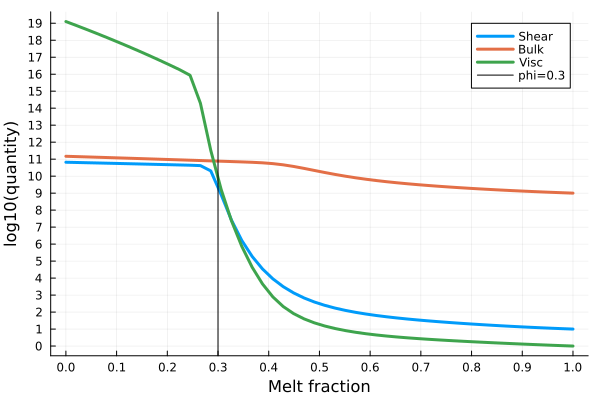

In [85]:
fig = plot(ylabel="log10(quantity)", xlabel="Melt fraction",
            yticks=range(0,20,step=1), xticks=range(0,1,step=0.1))

x_arr = collect(Float64, range(0.0, 1.0, length=50))

plot!(fig, x_arr, log10.(eval_rheoparam.(x_arr[:], "shear")), lw=3, label="Shear")
plot!(fig, x_arr, log10.(eval_rheoparam.(x_arr[:], "bulk") ), lw=3, label="Bulk")
plot!(fig, x_arr, log10.(eval_rheoparam.(x_arr[:], "visc") ), lw=3, label="Visc")
vline!([0.3], label="phi=0.3", color="black")

display(fig)

In [76]:
function once(day, ecc, visc; shear=60.0, bulk=260.0)

    # Rotational and orbital parameters
    ω = 2 * pi / (day * 24 * 60 * 60)     # Orbital frequency (2π / orbital period)

    # Internal structure:
    # First element is the innermost layer, last element is the outermost layer

    # Create a toy, homogeneous Enceladus-ish model
    ρ = prec[4300, 4300, 4300, 4300]  # Bulk density of each layer (kg m^-3)
    r = prec[3,                             # Radii of each boundary (km)
             4,                             # Radius of CMB. If no core, set this to a 1km.
             5,
             5.5,
             6.0] .* 1e6                  # Outer radius of solid surface
    μ = prec[shear, shear, shear, shear] .* 1e9         # Elastic shear modulus of each layer (Pa)
    κ = prec[bulk, bulk, bulk, bulk] .* 1e9    # Bulk modulus of each layer (set to a large number for incompressible material) (GPa)
    η = prec[visc, visc, visc, visc]        # Shear viscosity of each layer (Pa s)

    μc = 1im * μ*ω ./ (1im*ω .+ μ./η)       # Complex shear modulus for a Maxwell material. Change this for different rheologies.

    R = r[end]

    rr = expand_layers(r, nr=40)            # Expand the layers to a finer grid for numerical integration
    g = get_g(rr, ρ);                       # Get the gravitational acceleration on the fine grid

    tidal_solution = calculate_y(rr, ρ, g, μc, κ)       # Get "y-functions"

    k2 = tidal_solution[5, end, end] - 1               # Get k2 Tidal Love Number

    Edot = get_bulk_heating(tidal_solution, ω, R, ecc) # Get total power output in watts

    Mpl = 0.0
    for (i,v) in enumerate(ρ)
        ro = r[i+1]
        ri = r[i]
        Mpl += ρ[i] * (4 * pi / 3) * (ro-ri) * (ro^2 + ro*ri + ri^2)
    end

    # println(Mpl)

    return Edot / Mpl
end

once (generic function with 1 method)

## Power vs eccentricity

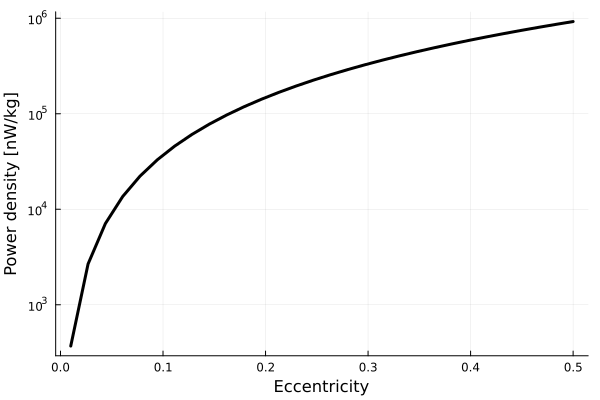

In [77]:
x_arr = collect(Float64, range(0.01, 0.5, length=30))
y_arr = zeros(Float64, length(x_arr))

for (i,x) in enumerate(x_arr)
    y_arr[i] = once(2.5, x, 1e15) * 1e9
end

plt = plot(xlabel="Eccentricity", ylabel="Power density [nW/kg]", yscale=:log10)
plot!(plt, x_arr, y_arr, label="", lw=3, lc=:black)
display(plt)

## Power vs period

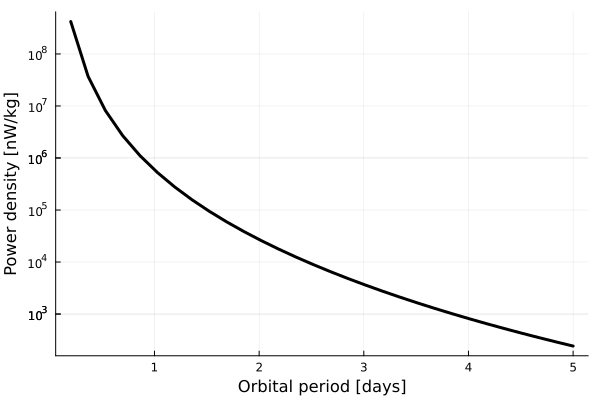

In [78]:
x_arr = collect(Float64, range(0.2, 5.0, length=30))
y_arr = zeros(Float64, length(x_arr))

for (i,x) in enumerate(x_arr)
    y_arr[i] = once(x, 0.05, 1e15) * 1e9
end

ymin = minimum(y_arr)/1.5
ymax = maximum(y_arr)*1.5
yticks = 10.0 .^ ceil.(range(log10(ymin), log10(ymax), 10))

plt = plot(xlabel="Orbital period [days]", ylabel="Power density [nW/kg]", yscale=:log10, yticks=yticks)
plot!(plt, x_arr, y_arr, label="", lw=3, lc=:black)
display(plt)

## Power vs viscosity

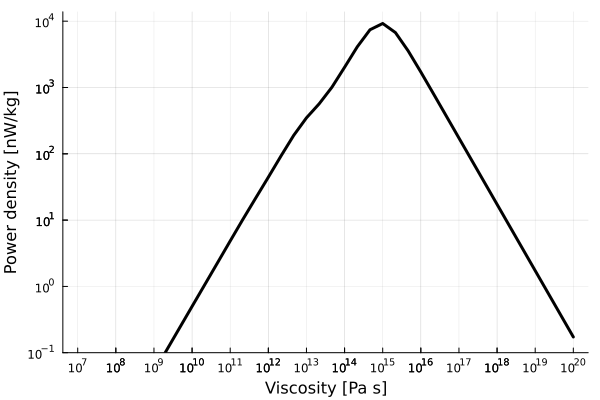

In [79]:
x_arr = collect(Float64, 10.0 .^ range(7, 20, length=40))
y_arr = zeros(Float64, length(x_arr))


for (i,x) in enumerate(x_arr)
    y_arr[i] = once(2.5, 0.05, x) * 1e9
end

ymin = 0.1
ymax = maximum(y_arr)*1.5
yticks = 10.0 .^ ceil.(range(log10(ymin), log10(ymax), 10))

plt = plot(xlabel="Viscosity [Pa s]", ylabel="Power density [nW/kg]",
                yscale=:log10, xscale=:log10, ylims=(ymin, ymax), yticks=yticks)
plot!(plt, x_arr, y_arr, label="", lw=3, lc=:black)
xticks!(plt, 10. .^ round.(log10.(x_arr[begin:2:end])))
display(plt)

## Power vs viscosity, period

In [80]:
x_inp = collect(Float64, 10.0 .^ range(4,  21,  length=50))
y_inp = collect(Float64,         range(0.5, 8.0, length=50))

x_arr = zeros(Float64, (length(x_inp), length(y_inp)))
y_arr = zeros(Float64, size(x_arr))
z_arr = zeros(Float64, size(x_arr))

z_min = 0.1

for (i,x) in enumerate(x_inp)
    for (j,y) in enumerate(y_inp)
        x_arr[i,j] = x
        y_arr[i,j] = y

        z = once(y, 0.05, x) * 1e9
        z_arr[i,j] = log10(max(z,z_min))
    end
end

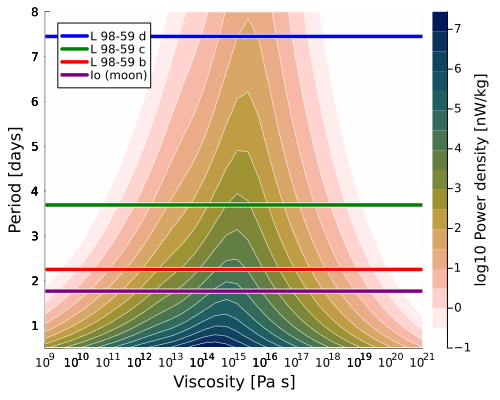

"/home/n/nichollsh/analysis/output/lovepy_cmap.pdf"

In [92]:
function add_hline!(plt, yloc, label; color=:black, lw=5)
    hline!(plt, [yloc], label="", color=:white, lw=lw)
    hline!(plt, [yloc], label=label, color=color, lw=lw-1.5)
end

cmap = cgrad(:batlowW, rev=true)
xticks = 10. .^ round.(log10.(x_inp[begin:2:end]))
yticks = round.(y_inp[begin:2:end])

plt = plot( xlabel="Viscosity [Pa s]", ylabel="Period [days]", size=(500,400),
            xticks=xticks, yticks=yticks, xlims=(1e9, Inf),
            xscale=:log10, colorbar_title="log10 Power density [nW/kg]", legend=:topleft)

contourf!(plt, x_inp, y_inp, z_arr', label="", cmap=cmap, lw=0.5, levels=16)
# scatter!(plt, x_arr, y_arr, marker_z=z_arr, cmap=cmap, label="", msw=0.8, msc=:white,)

add_hline!(plt, 7.4507, "L 98-59 d", color=:blue)
add_hline!(plt, 3.6907, "L 98-59 c", color=:green)
add_hline!(plt, 2.2531, "L 98-59 b", color=:red)
add_hline!(plt, 1.7691, "Io (moon)", color=:purple)

display(plt)
savefig(plt, "output/lovepy_cmap.pdf")

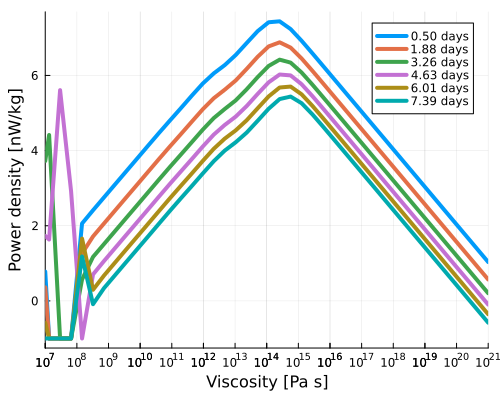

"/home/n/nichollsh/analysis/output/lovepy_cases.pdf"

In [82]:
xticks = 10. .^ round.(log10.(x_inp[begin:2:end]))

plt = plot( xlabel="Viscosity [Pa s]", ylabel="Power density [nW/kg]", size=(500,400),
            xticks=xticks, xlims=(1e7,Inf),
            xscale=:log10)

for (i,y) in enumerate(y_inp[begin:9:end])
    y_plt = z_arr[:,i]
    plot!(x_inp, y_plt, label=@sprintf("%.2f days",y), lw=4)
end

display(plt)
savefig(plt, "output/lovepy_cases.pdf")